# Projeto: Detecção doenças em lavouras de milho

### Objetivos

Esse projeto visa utilizar redes neurais (CNNs) para detectar diferentes doenças em lavouras de milho.

* Analisar distribuição das instâncias do dataset (treinamento e validação).
* Pré-processar e dividir o dataset corretamente.
* Aplicar normalização às imagens.
* Aplicar data augmentation para ampliar o treinamento e evitar overfitting.
* Utilizar transfer learning para extrair features de forma mais robusta.
* Desenvolver uma rede para classificar as doenças utilizando técnicas avançadas.
* Testar e validar modelo para produção.

### Autor

<a href='https://www.linkedin.com/in/pedro-henrique-amorim-de-azevedo/' target='_blank'>Pedro Henrique Amorim de Azevedo</a>

### Instalar e carregar bibliotecas necessárias

In [ ]:
!pip install -q numpy 
!pip install -q scipy
!pip install -q pandas
!pip install -q seaborn
!pip install -q matplotlib
!pip install -q tensorflow[and-cuda]
!pip install -q pillow 
!pip install -q scikit-learn

In [1]:
%matplotlib inline

import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, Multiply
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image

# Ocultar avisos desnecessários
import warnings
warnings.simplefilter('ignore', FutureWarning)

2025-04-07 14:26:12.506850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744046772.641601    5638 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744046772.679910    5638 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744046772.994027    5638 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744046772.994050    5638 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744046772.994051    5638 computation_placer.cc:177] computation placer alr

### Otimizações

Vamos utilizar o método `set_memory_growth` para habilitar a alocação dinâmica de VRAM da GPU.

In [2]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        details = tf.config.experimental.get_device_details(gpus[0])
        print("Modelo da GPU:", details.get("device_name", "Desconhecido"))

        # Definir alocação dinâmica
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
    else:
        print("Alocação dinâmica de VRAM habilitada com sucesso.")

Modelo da GPU: NVIDIA GeForce RTX 3060
Alocação dinâmica de VRAM habilitada com sucesso.


## Descrição do Dataset  

Este dataset contém imagens de folhas de milho classificadas em quatro categorias:  

<div style="display: flex; justify-content: center;">  
	<table style="border-collapse: collapse; width: 60%; text-align: center; font-size: 16px;">  
		<tr style="background-color: #f2f2f2;">  
			<th style="border: 1px solid #ddd; padding: 10px;">Classe</th>  
			<th style="border: 1px solid #ddd; padding: 10px;">Descrição</th>  
		</tr>  
		<tr>  
			<td style="border: 1px solid #ddd; padding: 10px;">saudavel</td>  
			<td style="border: 1px solid #ddd; padding: 10px;">Folhas de milho sem sinais visíveis de doenças.</td>  
		</tr>  
		<tr style="background-color: #f9f9f9;">  
			<td style="border: 1px solid #ddd; padding: 10px;">cercospora</td>  
			<td style="border: 1px solid #ddd; padding: 10px;">Mancha Cinzenta da Folha (*Cercospora zeae-maydis*).</td>  
		</tr>  
		<tr>  
			<td style="border: 1px solid #ddd; padding: 10px;">ferrugem</td>  
			<td style="border: 1px solid #ddd; padding: 10px;">Ferrugem do Milho (*Puccinia sorghi* ou *Puccinia polysora*).</td>  
		</tr>  
		<tr style="background-color: #f9f9f9;">  
			<td style="border: 1px solid #ddd; padding: 10px;">queima_do_norte</td>  
			<td style="border: 1px solid #ddd; padding: 10px;">Queima do Norte (*Exserohilum turcicum*).</td>  
		</tr>  
	</table>  
</div>   

### Carregando o dataset

Utilizaremos a própria estrutura de pastas para definir as classes das instâncias de treinamento .

In [3]:
dataset_path = 'datasets/'
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')

train_classes = os.listdir(train_path)
val_classes = os.listdir(val_path)

print('Pastas de treinamento: ', train_classes)
print('Pastas de validação: ', val_classes)

Pastas de treinamento:  ['saudavel', 'cercospora', 'ferrugem', 'queima_do_norte']
Pastas de validação:  ['saudavel', 'cercospora', 'ferrugem', 'queima_do_norte']


### Verificar distribuição das classes

Para que o treinamento seja o mais efetivo possível temos que nos certificar de que o dataset esteja bem distribuído entre as classes. Caso contrário, nosso modelo poderá ficar enviesado.

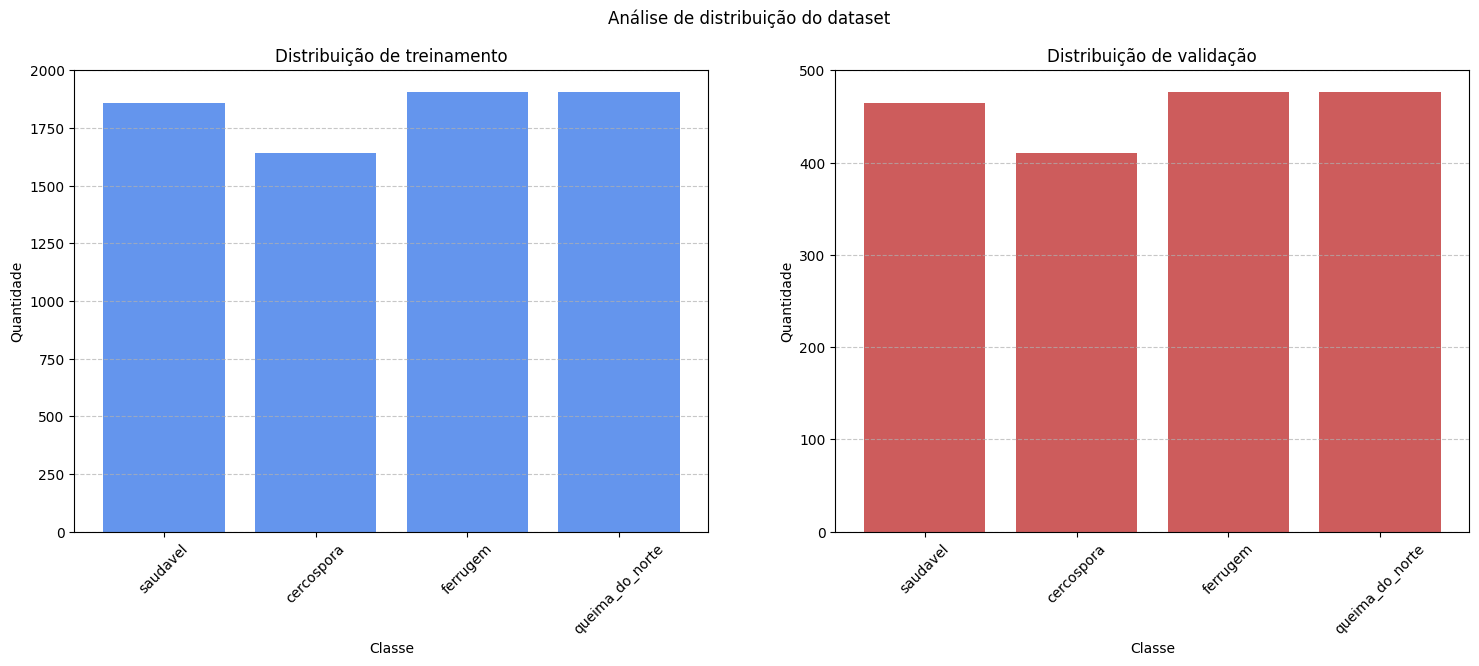

In [4]:
train_distribution = {}
for class_path in train_classes:
	_, _, files = next(os.walk(os.path.join(train_path, class_path)))
	train_distribution[class_path] = len(files)

val_distribution = {}
for class_path in val_classes:
	_, _, files = next(os.walk(os.path.join(val_path, class_path)))
	val_distribution[class_path] = len(files)


plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.bar(train_distribution.keys(), train_distribution.values(), color='cornflowerblue')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.title('Distribuição de treinamento')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.bar(val_distribution.keys(), val_distribution.values(), color='indianred')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.title('Distribuição de validação')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Análise de distribuição do dataset')
plt.show();

### Analisando amostras dos conjuntos de treinamento

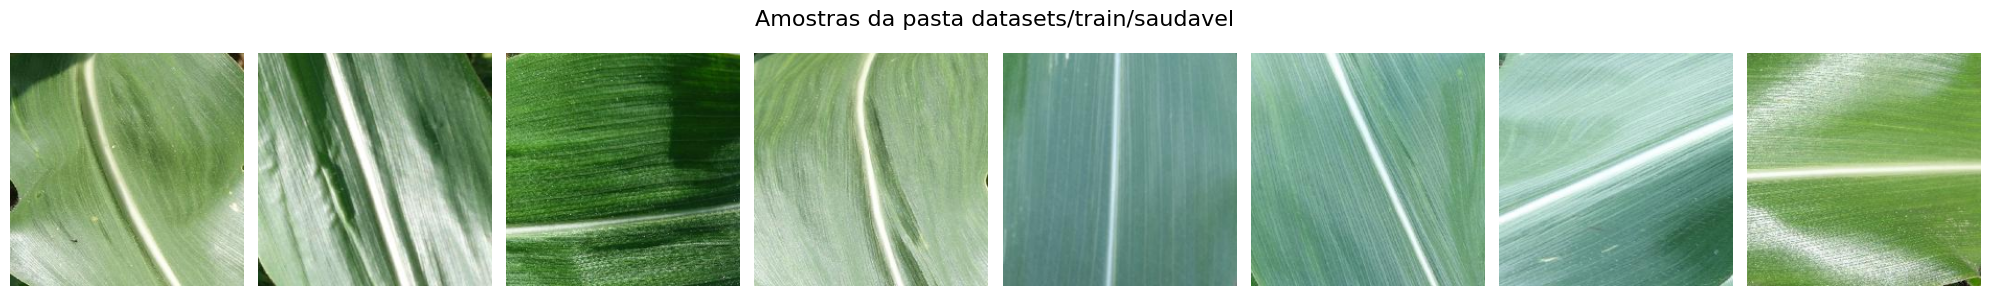

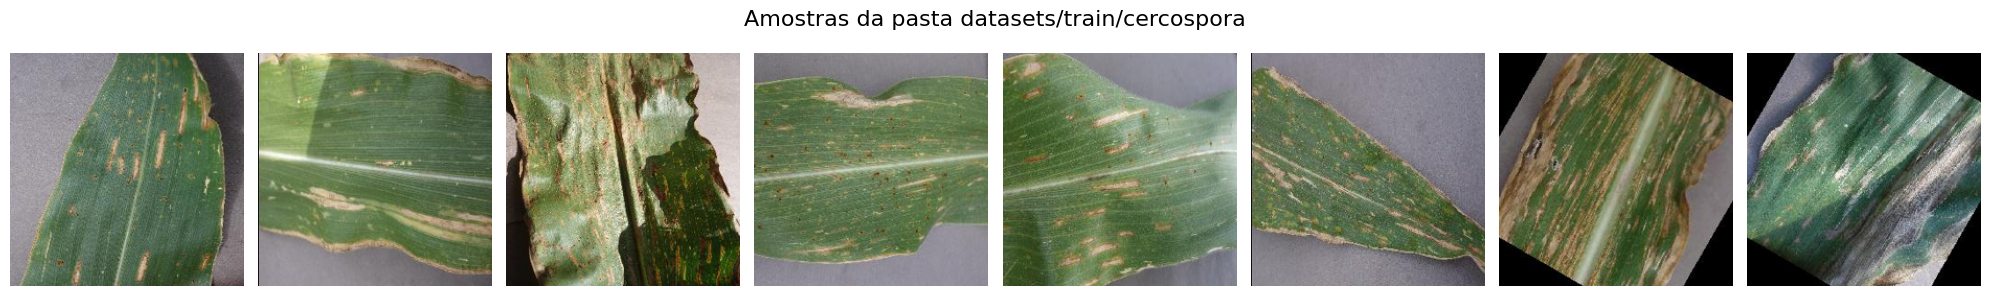

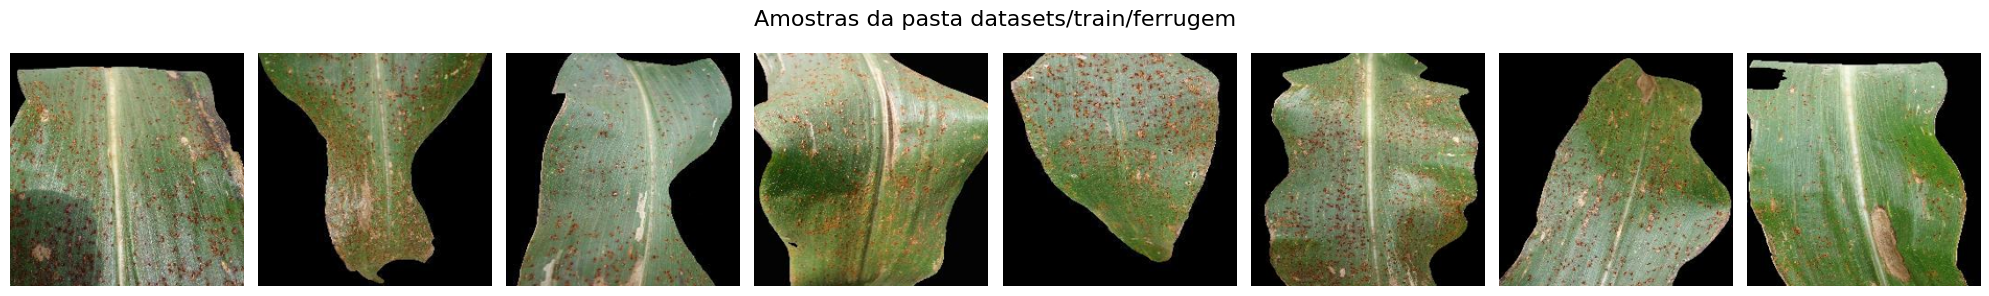

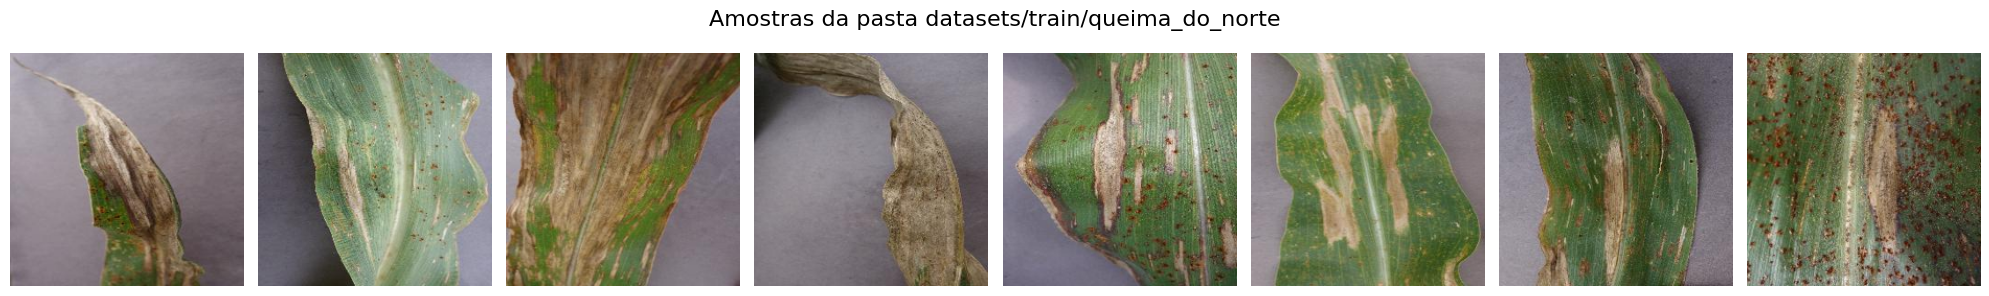

In [21]:
def plot_dataset_samples(data_class: str, num_images=8):
	selected_images = []

	for _ in range(num_images):
		class_path = os.path.join(train_path, data_class)
		image_choice = random.choice(os.listdir(class_path))  # Escolhe uma imagem aleatória
		image_path = os.path.join(class_path, image_choice)
		selected_images.append(image_path)

	fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

	for i, image_path in enumerate(selected_images):
		img = Image.open(image_path)  # Abrir a imagem
		img = img.resize((224, 224))  # Redimensionar para manter o padrão
		axes[i].imshow(img)
		axes[i].axis('off')

	plt.suptitle(f'Amostras da pasta {train_path}/{data_class}', fontsize=16)
	plt.tight_layout(rect=[0, 0, 1, 1.25])
	plt.show()


for train_class in train_classes:
	plot_dataset_samples(train_class)

# Criando a rede neural

### Usando transfer learning

Para acelerar o aprendizado do modelo final, utilizaremos a functional api do Keras e transfer learning mediante o uso de uma rede VGG16 pré-treinada, a qual já passou por um extenso treinamento no dataset Imagenet. Por esse motivo essa rede já é capaz de fazer uma extração bem robusta de padrões, o que nos auxiliará em nosso desenvolvimento. 

Essa decisão é estratégica pois poupará tempo, recurso computacionais, e investimento na criação de grandes datasets.

### Leaky ReLU
Normalmente, se utiliza a função de ativação ReLU para maioria dos casos. Mas a morte de neurônios causada pela ReLU pode impedir a rede de aprender bem. Logo testaremos a Leaky ReLU, a qual evita essa morte e permite que mais informações relevantes fluam pela rede. 

Pode ser útil para capturar menores detalhes.

### Inicialização 'he_normal'

Por padrão o Keras inicializa os pesos das camadas `Dense()` através da função `glorot_uniform`, mas para ajudar o gradiente a se propagar melhor na rede, utilizaremos `he_normal`. Esse inicializador é otimizado para ser utilizado juntamente com ativações ReLU e Leaky ReLU ajudando, assim, a rede a aprender melhor, evitando que fique presa nos mínimos locais devido a gradientes muito pequenos.

### Pooling paralelo e mecanismo de atenção
Se tivermos apenas uma camada `Flatten` para unir as saídas da rede, a rede talvez não consiga captar as importâncias necessárias. Após um tempo de estudos e várias tentativas, achei uma solução em usar uma camada de `GlobalAveragePooling2D` na saída. Mas como se trata de doenças com características semelhantes como forma e cores, seria válido tentar uma abordagem de duas camadas de pooling paralelas, que detectam caracteristicas diferentes e, logo após, adicionar uma camada de atenção para dar pesos às caracteristicas mais importantes.

Para entender essa abordagem, vamos supor que estejamos analisando uma folha de milho qualquer:

1. A abordagem de poolings paralelas captura:
	* Quantidade média de pústulas (AvgPool)
	* Áreas com maior concentração (MaxPool)

2. O mecanismo de atenção:
	* Dá peso alto para as pústulas alaranjadas
	* Dá peso baixo para áreas verdes saudáveis


In [ ]:
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32
EPOCHS = 80
LEARNING_RATE = 1e-4
PATIENCE = 15

# Carrega o modelo base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

# Congela camadas exceto as últimas 4 para um melhor fine-tunning (tentar 8)
for layer in base_model.layers[:-4]:
	layer.trainable = False

# Duas poolings paralelas para capturar diferentes características
x1 = GlobalAveragePooling2D()(base_model.output) # Captura intensidade média
x2 = GlobalMaxPooling2D()(base_model.output) # Captura picos de intensidade
x = Concatenate()([x1, x2])  # Combina as camadas de pooling

# Gera pesos entre 0 e 1
attention = Dense(1024, activation='sigmoid', kernel_regularizer=l2(0.01))(x)
x = Multiply()([x, attention]) # Multiplica as características pelo peso gerado

# Com a regularização L2 penalizamos pesos muito altos. Reduz a dominancia de certos neuronios. 
# Deixa o modelo menos preso a certas características. Faz ele aproveitar mais todas as características.
x = Dense(1024, kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x) 
x = Dropout(0.5)(x)

x = Dense(512, kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

# Aumentar o L2 para formar uma confiaça mais balanceada
x = Dense(256, kernel_initializer='he_normal', kernel_regularizer=l2(0.02))(x)
x = BatchNormalization()(x)
# Um alpha maior aqui permite que mais características negativas passem, servindo como regularização
# Ajuda a puxar a ativação correta por deixar mais sensível a variações
x = LeakyReLU(alpha=0.3)(x)  
x = Dropout(0.3)(x)

output = Dense(4, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=base_model.input, outputs=output)

# Otimizador com weight decay
optimizer = Adam(learning_rate=LEARNING_RATE, weight_decay=1e-5) # weight_decay para regularização geral
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

# Imprimir como ficou o modelo
model.summary()

I0000 00:00:1744046788.148298    5638 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8381 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/pedro/anaconda3/envs/intellisis/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 17,478,212 (66.67 MB)

 Trainable params: 9,839,364 (37.53 MB)

 Non-trainable params: 7,638,848 (29.14 MB)

### Data augmentation

Quanto mais instâncias de cada classe estiverem disponíveis para o treinamento do modelo, melhor será a capacidade do nosso modelo generalizar. 

Vamos instanciar um ImageDataGenerator para aumentar o nosso dataset de forma sintética. Seu funcionamento consiste em gerar, a cada época de treinamento, uma uma imagem sintética com diferentes propriedades como rotação, inversão horizontal, vertical, deslocamento, entre outras.

Isso significa que a cada época de treinamento, o nosso modelo verá a mesma imagem sempre de uma maneira diferente, como se fosse a primeira vez. Isso ajuda a evitar overfitting e aumentar a capacidade de generalizacao em datasets menores.

In [5]:
train_datagen = ImageDataGenerator(
	rescale=1./255,
	rotation_range=45,
	width_shift_range=0.25,
	height_shift_range=0.25,
	shear_range=0.25,
	zoom_range=0.25,
	horizontal_flip=True,
	vertical_flip=True,
	brightness_range=[0.7, 1.3],
	fill_mode='nearest',
	channel_shift_range=20.0
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
def load_images(directory, datagen):
	print(f'Carregando {directory}')
	classes = os.listdir(directory)
	
	# Mapear os nomes de classe para um índice
	class_idx = { class_name: idx for idx, class_name in enumerate(classes) }
	
	# Debug
	# print(class_idx)
	
	image_paths = []
	labels = []
	
	for class_name in classes:
		class_folder_path = os.path.join(directory, class_name)
		
		# Listar todos os arquivos na pasta da classe
		for filename in os.listdir(class_folder_path):
			if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG')):
				full_image_path = os.path.join(class_folder_path, filename)
				image_paths.append(full_image_path)
				labels.append(class_idx[class_name])        
	
	# Carregar e pré-processar todas as imagens
	loaded_images = []
	for img_path in image_paths:
		img = load_img(img_path, target_size=IMG_SIZE)
		# Adiciona canais RGB ou seja (*IMG_SIZE, 3)
		img_array = img_to_array(img)
		loaded_images.append(img_array)

	images_array = np.array(loaded_images)
	
	# Converter labels para one-hot encoding
	labels_array = np.array(labels)
	one_hot_labels = to_categorical(labels_array, num_classes=len(classes))
	
	data_generator = datagen.flow(
		images_array, 
		one_hot_labels, 
		batch_size=BATCH_SIZE, 
		shuffle=True
	)
	
	return data_generator


# Carrega os dados
train_generator = load_images(train_path, train_datagen)
validation_generator = load_images(val_path, val_datagen)


Carregando datasets/train
Carregando datasets/val


### Treinando o modelo

In [11]:
# Callbacks
callbacks = [
	EarlyStopping(monitor='val_accuracy', patience=PATIENCE, mode='max', restore_best_weights=True, verbose=1),
	ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=PATIENCE//3, min_lr=1e-6, verbose=1),
	ModelCheckpoint(os.path.join('models', 'classificador_checkpoint.keras'), monitor='val_accuracy', save_best_only=True, mode='max')
]

history = model.fit(
	train_generator,
	steps_per_epoch=len(train_generator),
	epochs=EPOCHS,
	validation_data=validation_generator,
	validation_steps=len(validation_generator),
	callbacks=callbacks,
	verbose=1
)


/home/pedro/anaconda3/envs/intellisis/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80


I0000 00:00:1744028016.557482    7778 service.cc:152] XLA service 0x7bf92801bbe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744028016.557505    7778 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-07 09:13:36.738996: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744028017.439581    7778 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-07 09:13:39.348395: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3457', 48 bytes spill stores, 48 bytes spill loads

2025-04-07 09:13:39.403825: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3457'

  1/229 ━━━━━━━━━━━━━━━━━━━━ 1:20:54 21s/step - AUC: 0.5555 - accuracy: 0.2500 - loss: 52.8539

I0000 00:00:1744028033.781054    7778 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  6/229 ━━━━━━━━━━━━━━━━━━━━ 1:07 303ms/step - AUC: 0.5892 - accuracy: 0.2681 - loss: 52.6373

2025-04-07 09:13:57.605984: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3457', 112 bytes spill stores, 112 bytes spill loads

2025-04-07 09:13:57.933170: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3457', 4 bytes spill stores, 4 bytes spill loads

2025-04-07 09:13:57.986112: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3457', 48 bytes spill stores, 48 bytes spill loads



229/229 ━━━━━━━━━━━━━━━━━━━━ 124s 450ms/step - AUC: 0.9098 - accuracy: 0.7251 - loss: 46.5068 - val_AUC: 0.9840 - val_accuracy: 0.8890 - val_loss: 32.0264 - learning_rate: 1.0000e-04
Epoch 2/80
229/229 ━━━━━━━━━━━━━━━━━━━━ 85s 371ms/step - AUC: 0.9937 - accuracy: 0.9379 - loss: 28.4094 - val_AUC: 0.9765 - val_accuracy: 0.8633 - val_loss: 19.8876 - learning_rate: 1.0000e-04
Epoch 3/80
229/229 ━━━━━━━━━━━━━━━━━━━━ 86s 373ms/step - AUC: 0.9949 - accuracy: 0.9441 - loss: 17.5716 - val_AUC: 0.9974 - val_accuracy: 0.9650 - val_loss: 12.2407 - learning_rate: 1.0000e-04
Epoch 4/80
229/229 ━━━━━━━━━━━━━━━━━━━━ 85s 372ms/step - AUC: 0.9955 - accuracy: 0.9542 - loss: 10.9744 - val_AUC: 0.9976 - val_accuracy: 0.9606 - val_loss: 7.6959 - learning_rate: 1.0000e-04
Epoch 5/80
229/229 ━━━━━━━━━━━━━━━━━━━━ 86s 374ms/step - AUC: 0.9965 - accuracy: 0.9581 - loss: 6.9158 - val_AUC: 0.9988 - val_accuracy: 0.9727 - val_loss: 4.8711 - learning_rate: 1.0000e-04
Epoch 6/80
229/229 ━━━━━━━━━━━━━━━━━━━━ 86s 376m

### Recuperando o melhor modelo

As vezes o `EarlyStopping` pode não entrar em ação e recuperar os melhores pesos. Sendo assim, vamos carregar o melhor modelo salvo pelo `ModelCheckpoint` e avaliá-lo.

In [11]:
best_model = load_model('models/classificador_checkpoint.keras')

eval = best_model.evaluate(validation_generator)
eval
#print(f'Validação:\n  - Perda: {val_loss}\n  - Acurácia: {val_acc}')

58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - AUC: 0.9997 - accuracy: 0.9958 - loss: 0.0307


[0.037668224424123764, 0.9923455715179443, 0.9996444582939148]

### Avaliando o modelo

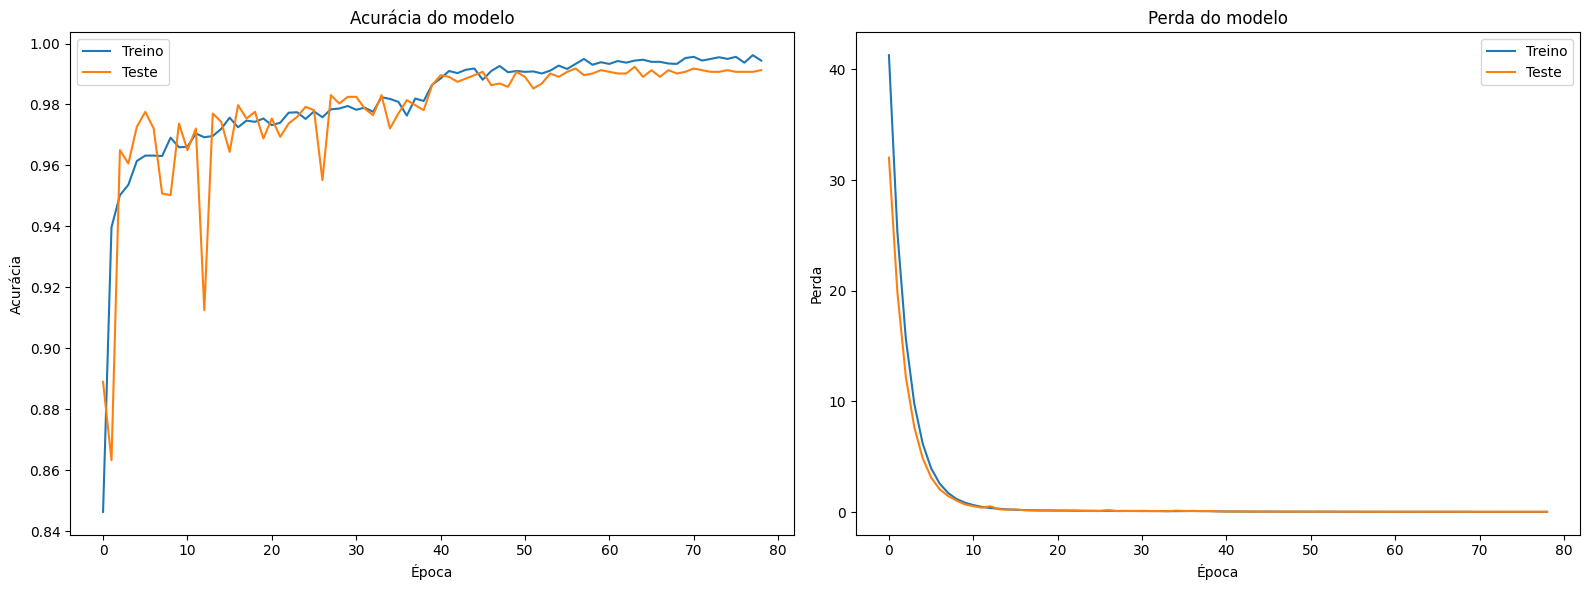

In [13]:
plt.figure(figsize=(16, 6))

# Histórico de acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper left')

# Histórico de perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do modelo')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper right')

plt.tight_layout()
plt.show()

Como podemos ver, nosso modelo começa a estabilizar por volta da décima quarta época. Porém, como implementamos o `ReduceLROnPlateau`, o treinamento reduz a taxa de aprendizado para meados de 10e-6 e passa para um estado de fine-tuning bem pequeno até o `EarlyStopping` detectar que não é necessário dar prosseguimento ao treinamento, o qual parou na época 79, mas restaurou os pesos da época 64.

### Relatório de classificação e matriz de confusão

Vamos criar uma função para plotar na mesma figura tanto o classification report como a matriz de confusão.

In [13]:
def plot_conf_matrix_report(y_pred, y_test):
  plt.figure(figsize=(22, 8))

  # Subplot 1 - Classification Report
  plt.subplot(1, 2, 1)
  plt.title('Classification Report')
  clf_report = classification_report(y_test, y_pred, output_dict=True)
  report_df = pd.DataFrame(clf_report).iloc[:-1, :].T  # Remove 'support'
  sns.heatmap(report_df, annot=True, cmap='coolwarm', fmt=".2f")

  # Subplot 2 - Confusion Matrix
  plt.subplot(1, 2, 2)
  plt.title('Confusion Matrix')
  conf_matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  
  plt.tight_layout()
  plt.show()

Vamos nos aproveitar da capacidade do `validation_generator` de liberar dados em batches e criar uma função especial para fazer as predições. 

Eu gosto muito de usar essa funcionalidade pois é útil para fazer predições em datasets grandes.

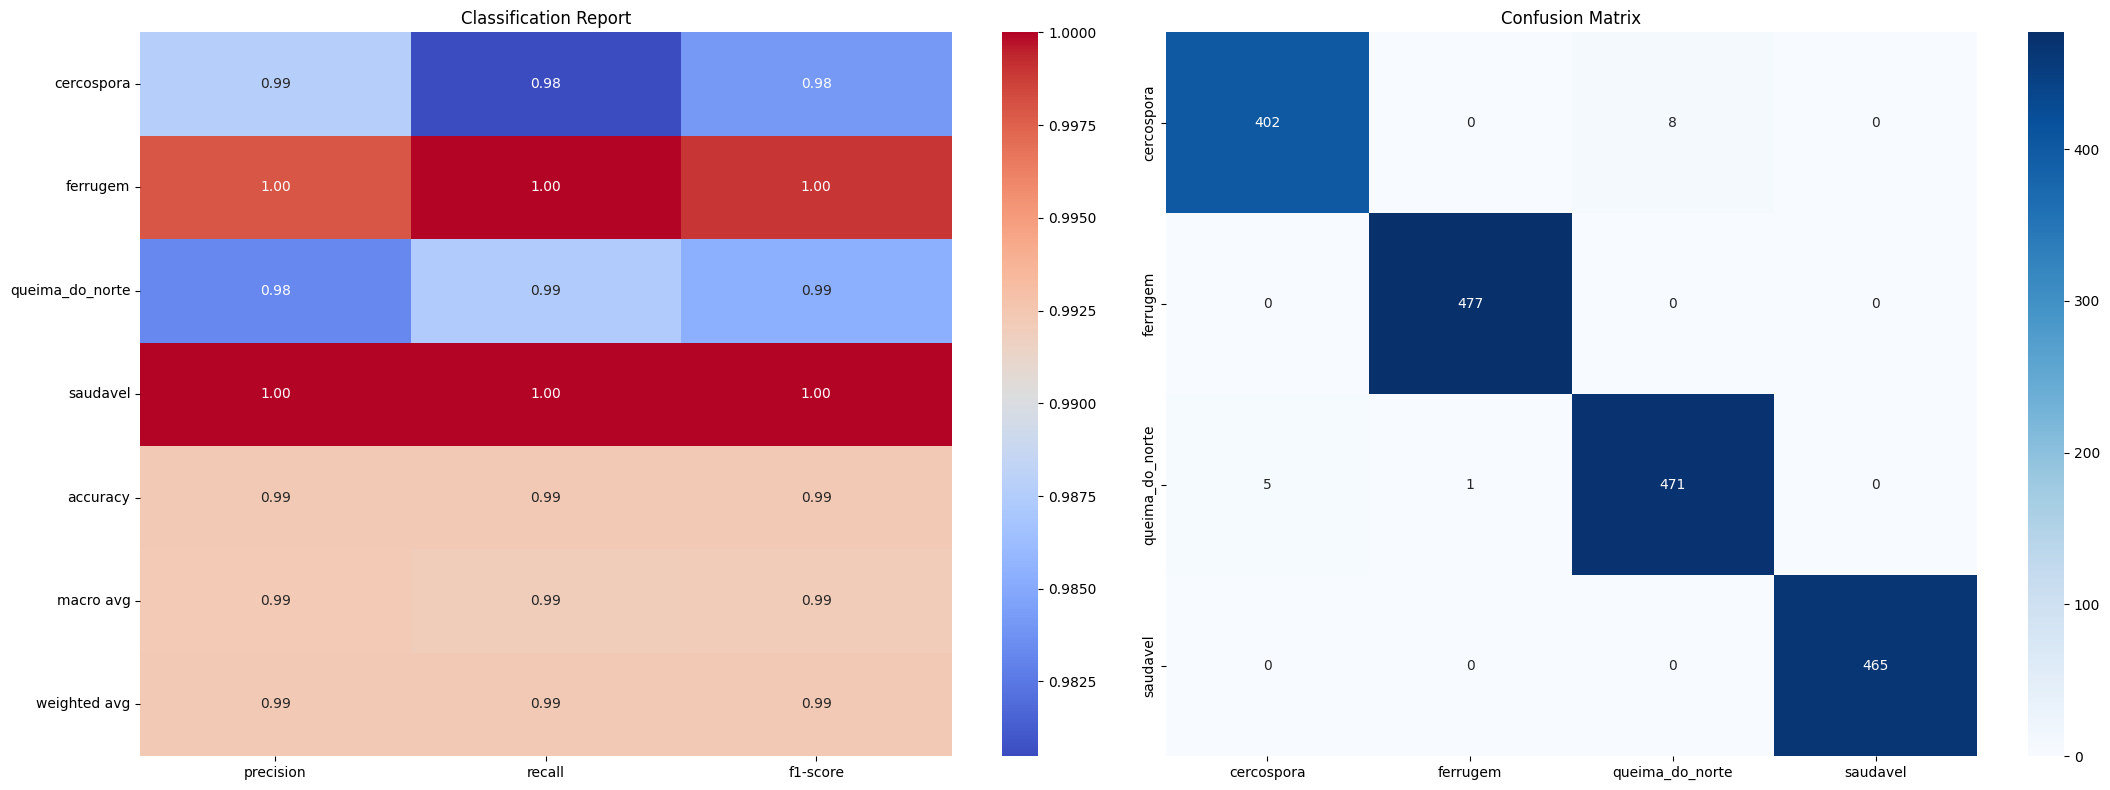

In [14]:
def evaluate_with_custom_generator(model, validation_generator):
	validation_generator.reset()

	# Listas para armazenar resultados
	all_y_true = []
	all_y_pred = []

	# Iterar por todos os batches
	for i in range(len(validation_generator)):
		x, y = next(validation_generator)

		# Fazer previsões
		pred = model.predict(x, verbose=0)

		# Converter de one-hot para indice das classes: [0, 1, 2, 3]
		# Como a saída é softmax, pegamos o indice do maior valor
		y_true_batch = np.argmax(y, axis=1)
		y_pred_batch = np.argmax(pred, axis=1)

		# Vamos criar uma função numpy-like que ao chamá-la ela se aplica a todos os elementos de um array numpy
		# Converte de indice para o nome da classe
		get_named_class = np.vectorize(lambda c: val_classes[c])

		# Armazenar resultados
		all_y_true.extend(get_named_class(y_true_batch))
		all_y_pred.extend(get_named_class(y_pred_batch))

	return np.array(all_y_true), np.array(all_y_pred)


y_true, y_pred = evaluate_with_custom_generator(best_model, validation_generator)
plot_conf_matrix_report(y_pred, y_true)

# Resultados

Das 1829 imagens de validação, o modelo treinado errou em apenas 14 casos, o que representa apenas 0.76% do dataset. Ao observar o relatório de classificação, podemos notar que o f1-score foi 0.98 ou mais para todas as classes. Além do mais, tivemos uma média de 0.99 para precisão, recall e f1-score! 

Dado esse treinamento tão bem sucedido, logo mais vamos salvar o nosso modelo e testá-lo visualmente.

In [19]:
def preprocess_image(path: str):
	# Carrega a imagem no tamanho desejado
	img = load_img(path, target_size=IMG_SIZE)
	# Adiciona os canais RGB: img.shape = (224, 224, 3)
	img_arr = img_to_array(img)
	# Adiciona o numero de imagens: img.shape = (1, 224, 224, 3)
	img_arr = np.expand_dims(img_arr, axis=0)
	img_arr = img_arr / 255.0
	return img_arr

def plot_results(data_class: str, num_images=8):
	selected_images = []
	for _ in range(num_images):
		class_path = os.path.join(val_path, data_class)
		image_choice = random.choice(os.listdir(class_path))  # Escolhe uma imagem aleatória
		image_path = os.path.join(class_path, image_choice)
		selected_images.append(image_path)

	predictions = []
	confidences = []
	for image in selected_images:
		img = preprocess_image(image)
		pred = best_model.predict(img, verbose=0)
		y_pred = np.argmax(pred, axis=1)[0]
		confidences.append(np.max(pred))  # Pega a maior probabilidade
		predictions.append(val_classes[y_pred]) 

	fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

	for i, (image, prediction, confidence) in enumerate(zip(selected_images, predictions, confidences)):
		img = Image.open(image)  # Abrir a imagem
		img = img.resize(IMG_SIZE)  # Redimensionar para manters o padrão
		axes[i].imshow(img)
		axes[i].set_title(f'{prediction}\nConfiança: {confidence*100:.1f}%')
		axes[i].axis('off')
		

	plt.suptitle(f'Predições na pasta {val_path}/{data_class}', fontsize=16)
	plt.tight_layout(rect=[0, 0, 1, 1.1]) 
	plt.show()

### Visualizando as predições na pasta de validação

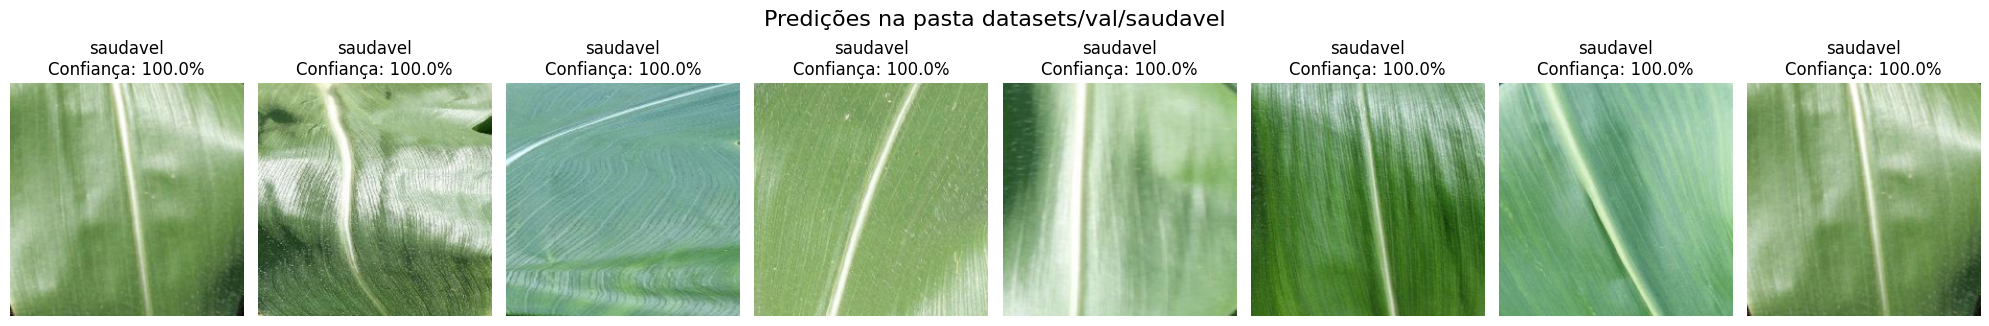

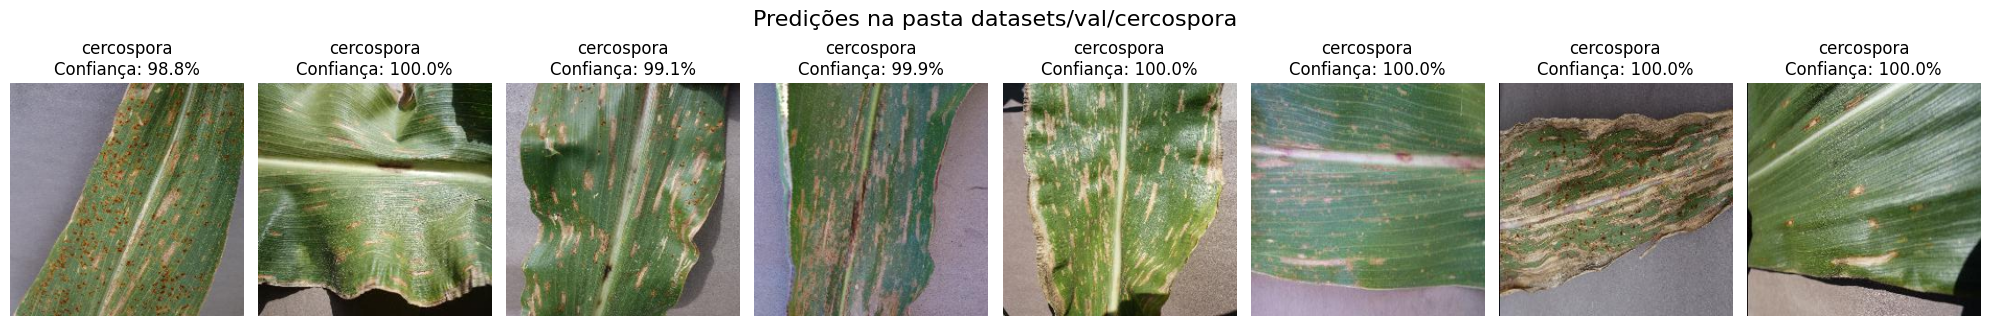

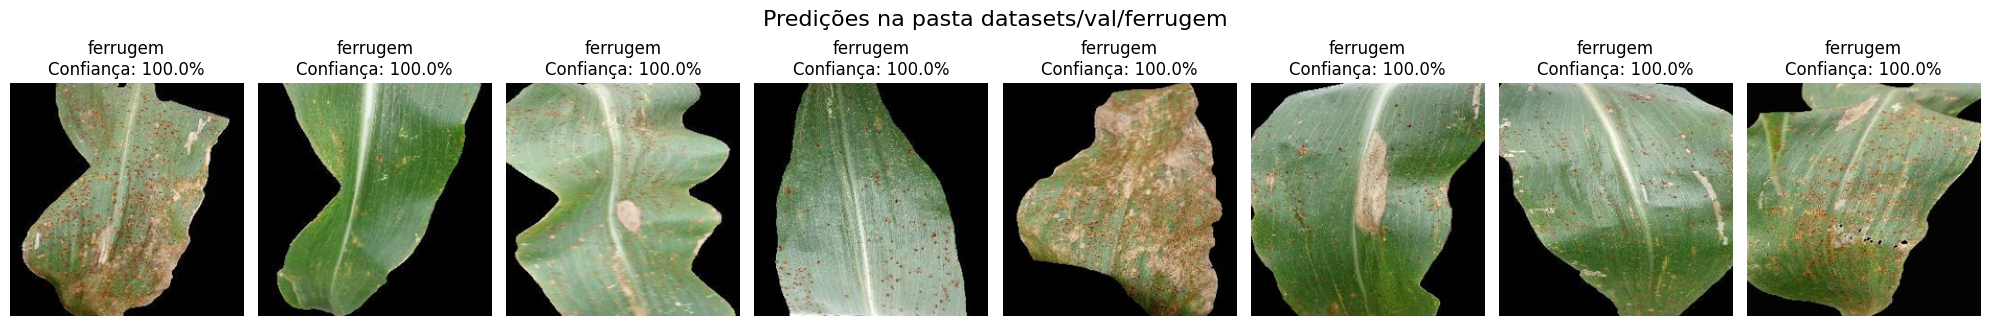

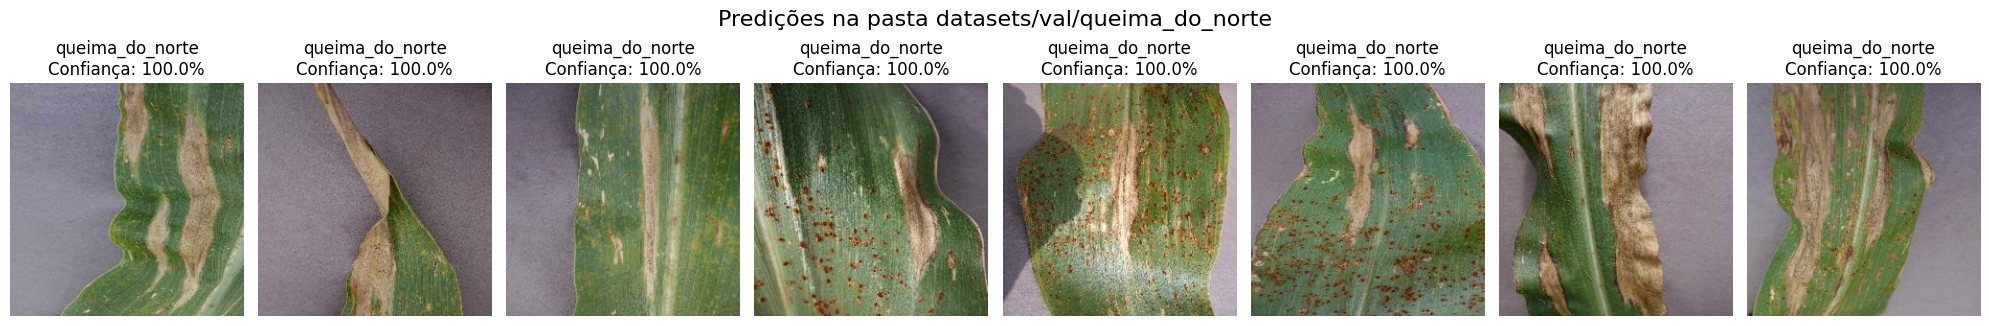

In [20]:
for class_name in val_classes:
	plot_results(class_name)

### Usando Grad-CAM

Vamos usar Grad-CAM (Gradient-weighted Class Activation Mapping) para ver como o nosso modelo age durante a predição. Isso é bastante útil para saber como as técnicas que empregamos agem na forma do modelo atuar.

In [45]:
def get_grad_cam(model, img_path):
    # Carrega e pré-processa a imagem
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Lembrar de normalizar como no treino

    # Pegar a última camada convolucional
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            layer_name = layer.name
            break

    # Cria um modelo intermediário que fornece a saída da camada alvo + saída final do modelo
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    # Vamos gravar as operações com o GradientTape
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)  # Forward pass
        class_index = np.argmax(predictions[0])  # Classe mais provável
        class_score = predictions[:, class_index]  # Score dessa classe

    # Calcula o gradiente da classe em relação às ativações da camada convolucional
    grads = tape.gradient(class_score, conv_outputs)

    # Calcula a média do gradiente em cada canal
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplica cada canal de ativação pelo peso do gradiente correspondente
    conv_outputs = conv_outputs[0]  # Remove a dimensão dos batches
    heatmap = np.dot(conv_outputs, pooled_grads[..., tf.newaxis]) # ellipsis (adicionar nova dimensão depois das outras)
    heatmap = tf.squeeze(heatmap)  # Remove dimensões 1 extras

    # Normaliza o heatmap entre 0 e 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    return heatmap, class_index


def show_grad_cam(model, img_path):
    heatmap, class_index = get_grad_cam(model, img_path)
    predicted_class = val_classes[class_index]

    # Carrega a imagem original
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)

    # Redimensiona o heatmap para o tamanho da imagem
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Sobrepõe o heatmap com a imagem original (50% transparente)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)
    
    # Converte de BGR (do cv2) para RGB (matplotlib)
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    # Plota a imagem com heatmap
    plt.figure(figsize=(8, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Imagem original')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Mapa de calor')
    plt.axis('off')
    
    plt.suptitle(f'Grad-CAM: {predicted_class}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.98]) 
    plt.show()

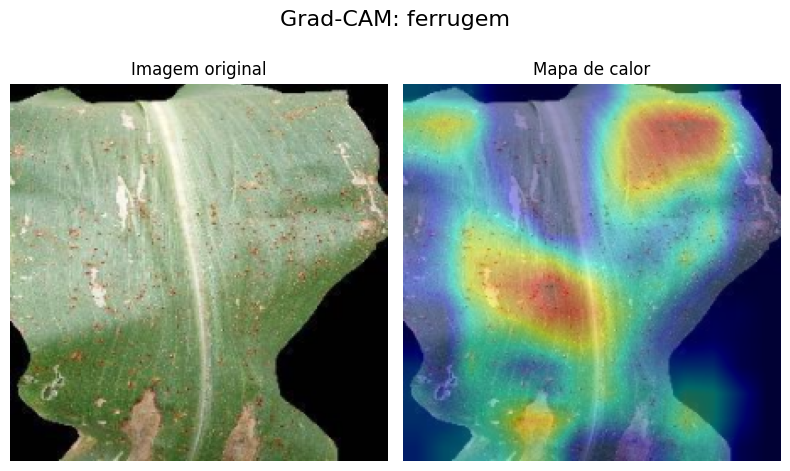

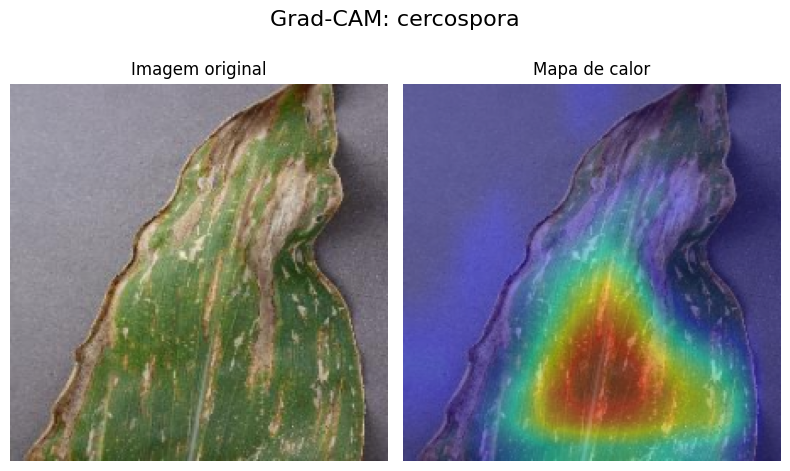

In [46]:
show_grad_cam(best_model, 'datasets/val/ferrugem/RS_Rust 1626_flipLR.JPG')
show_grad_cam(best_model, 'datasets/val/cercospora/0ba90f90-3702-438a-908b-85871f3a34cb___RS_GLSp 4342.JPG')